<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMDB-Movie-Review-Sentiment-Classification" data-toc-modified-id="IMDB-Movie-Review-Sentiment-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMDB Movie Review Sentiment Classification</a></span></li><li><span><a href="#Purpose" data-toc-modified-id="Purpose-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Process" data-toc-modified-id="Process-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process</a></span></li><li><span><a href="#Configure-notebook,-import-libraries,-and-import-dataset" data-toc-modified-id="Configure-notebook,-import-libraries,-and-import-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Configure notebook, import libraries, and import dataset</a></span><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Define-global-variables" data-toc-modified-id="Define-global-variables-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Define global variables</a></span></li><li><span><a href="#Import-labeled-data" data-toc-modified-id="Import-labeled-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Import labeled data</a></span></li></ul></li><li><span><a href="#Examine-the-data" data-toc-modified-id="Examine-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examine the data</a></span></li><li><span><a href="#Cleaning-and-preprocessing" data-toc-modified-id="Cleaning-and-preprocessing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Cleaning and preprocessing</a></span><ul class="toc-item"><li><span><a href="#Load-training-data" data-toc-modified-id="Load-training-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Load training data</a></span></li><li><span><a href="#Write-helper-functions" data-toc-modified-id="Write-helper-functions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Write helper functions</a></span><ul class="toc-item"><li><span><a href="#Sentence-cleaner" data-toc-modified-id="Sentence-cleaner-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Sentence cleaner</a></span></li><li><span><a href="#Review-tokenizer" data-toc-modified-id="Review-tokenizer-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Review tokenizer</a></span></li></ul></li><li><span><a href="#Process-training-data" data-toc-modified-id="Process-training-data-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Process training data</a></span></li><li><span><a href="#Train-Word2Vec" data-toc-modified-id="Train-Word2Vec-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Train Word2Vec</a></span></li><li><span><a href="#Centroid-development" data-toc-modified-id="Centroid-development-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Centroid development</a></span><ul class="toc-item"><li><span><a href="#Feature-array-creation" data-toc-modified-id="Feature-array-creation-6.5.1"><span class="toc-item-num">6.5.1&nbsp;&nbsp;</span>Feature array creation</a></span><ul class="toc-item"><li><span><a href="#Write-helper-function" data-toc-modified-id="Write-helper-function-6.5.1.1"><span class="toc-item-num">6.5.1.1&nbsp;&nbsp;</span>Write helper function</a></span></li><li><span><a href="#Tokenize-and-clean-labeled-training-data" data-toc-modified-id="Tokenize-and-clean-labeled-training-data-6.5.1.2"><span class="toc-item-num">6.5.1.2&nbsp;&nbsp;</span>Tokenize and clean labeled training data</a></span></li><li><span><a href="#Create-feature-set-centroids" data-toc-modified-id="Create-feature-set-centroids-6.5.1.3"><span class="toc-item-num">6.5.1.3&nbsp;&nbsp;</span>Create feature set centroids</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Model-training-and-evaluation" data-toc-modified-id="Model-training-and-evaluation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model training and evaluation</a></span><ul class="toc-item"><li><span><a href="#Kaggle-model" data-toc-modified-id="Kaggle-model-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Kaggle model</a></span></li><li><span><a href="#Standard-write-up-models" data-toc-modified-id="Standard-write-up-models-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Standard write-up models</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

<h1>IMDB Movie Review Sentiment Classification</h1>

<img style="float: left; margin-right: 15px; width: 30%; height: 30%;" src="images/imdb.jpg" />

# Purpose

The overall goal of this set of write-ups is to explore a number of machine learning algorithms utilizing natural language processing (NLP) to classify sentiment IMDB movie reviews.

The specific goals of this write-up include:
1. Create a set of word embeddings from the IMDb movie review text utilizing [Word2vec](https://en.wikipedia.org/wiki/Word2vec)
2. Cluster the embeddings utilizing a K-nearest neighbors algorithm into a set of centroids
2. Run the models from the [last write-up](./Model-06.ipynb) against the centroid feature set
3. Determine if the centroid feature set improves our ability to correctly classify movie review sentiment

This series of write-ups is inspired by the Kaggle [
Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial) competition.    

Dataset source:  [IMDB Movie Reviews](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)

# Process

Previously covered [here](./Model-06.ipynb#Process).

# Configure notebook, import libraries, and import dataset

## Import libraries

In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import set_option

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans


# http://www.nltk.org/index.html
# pip install nltk
import nltk
from nltk.corpus import stopwords


# Creating function implementing punkt tokenizer for sentence splitting
import nltk.data

# Only need this the first time...
# nltk.download('punkt')


# https://www.crummy.com/software/BeautifulSoup/bs4/doc/
# pip install BeautifulSoup4
from bs4 import BeautifulSoup


# https://pypi.org/project/gensim/
# pip install gensim
from gensim.models import word2vec


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define global variables

In [2]:
seed = 10
np.random.seed(seed)

# Opens a GUI that allows us to download the NLTK data
# nltk.download()

dataPath = os.path.join('.', 'datasets', 'imdb_movie_reviews')
labeledTrainData = os.path.join(dataPath, 'labeledTrainData.tsv')

## Import labeled data

In [3]:
df = pd.read_csv(labeledTrainData, sep = '\t', header = 0, quoting = 3)

# Examine the data

Previously covered [here](./Model-06.ipynb#Examine-the-data).

# Cleaning and preprocessing

## Load training data

(Previous process justification and methodology also previously covered [here](./Model-06.ipynb#Cleaning-and-preprocessing).)

First, read in the labeled training data (which we've done before) as well as the unlabeled training data (which is new to this write-up).  The more data we can feed to Word2Vec the better, and this will help the algorithm associate related words more accurately.

In [6]:
# Pull in the labeled data
labeledTrainData = os.path.join(dataPath, 'labeledTrainData.tsv')
df = pd.read_csv(labeledTrainData, sep = '\t', header = 0, quoting = 3)

# Pull in the unlabeled data since it can also be utilized by Word2Vec
unlabeledTrainData = os.path.join(dataPath, 'unlabeledTrainData.tsv')
dfUn = pd.read_csv(unlabeledTrainData, sep = '\t', header = 0, quoting = 3)

In [7]:
# Validation
print('df.shape :', df.shape)
print('dfUn.shape :', dfUn.shape)

df.shape : (25000, 3)
dfUn.shape : (50000, 2)


## Write helper functions

Word2Vec expects single sentences as inputs, and each sentence formated as a list of words (i.e. a list of lists).  Let's write two functions to achieve this next.

### Sentence cleaner

Take a given sentence and process/clean it (i.e. remove HTML and other cruft, lower case the text, etc.).

In [8]:
# Update stop word helper function to output a list of words

# Clean IMDB review text
def cleanReview(review, removeStopWords = False):
    # Convert the stop words to a set
    stopWords = set(stopwords.words("english"))
    
    # Remove HTML
    clean = BeautifulSoup(review)
    
    # Remove non-alpha chars
    clean = re.sub("[^a-zA-Z]", ' ', clean.get_text())
    
    # Convert to lower case and "tokenize"
    clean = clean.lower().split()
    
    # Remove stop words
    if removeStopWords:
        clean = [x for x in clean if not x in stopWords]
    
    # Return results
    return clean

A quick examination of the output:

In [9]:
# Examine
cleanReview(df.iloc[25,2])[:12]

['looking',
 'for',
 'quo',
 'vadis',
 'at',
 'my',
 'local',
 'video',
 'store',
 'i',
 'found',
 'this']

In [10]:
# Examine
cleanReview(dfUn.iloc[0,1])[:12]

['watching',
 'time',
 'chasers',
 'it',
 'obvious',
 'that',
 'it',
 'was',
 'made',
 'by',
 'a',
 'bunch']

### Review tokenizer

Given a blob of review text tokenize it into individual sentences, and then feed those sentences to the sentence cleaner function for processing.  The final output should be a list of lists suitable for use by Word2Vec.

In [11]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def createSentences(review, tokenizer, remove_stopwords = False):
    # Init container to hold results
    sentences = []
    
    # Split review string into sentences
    tokenSentences = tokenizer.tokenize(review.strip())

    # Clean the sentences via cleanReview() function
    for s in tokenSentences:
        # If a sentence is empty, skip it
        if len(s) > 0:
            # Clean sentence
            sentences.append( cleanReview( s, remove_stopwords ))
    
    # Return list of clean sentences
    return sentences

A quick examination of the output:

In [12]:
# Examine
_ = createSentences(df.iloc[25,2], tokenizer)
print(_[0][:12])
print(len(_))

['looking', 'for', 'quo', 'vadis', 'at', 'my', 'local', 'video', 'store', 'i', 'found', 'this']
8


In [13]:
# Examine
_ = createSentences(dfUn.iloc[0,1], tokenizer)
print(_[0][:12])
print(len(_))

['watching', 'time', 'chasers', 'it', 'obvious', 'that', 'it', 'was', 'made', 'by', 'a', 'bunch']
5


## Process training data 

Now we'll combine the labeled and unlabeled training data and output the list of lists utilizing the helper functions we wrote above:

In [14]:
combined = []

for s in df.iloc[:,2]:
    combined += createSentences(s, tokenizer)

In [15]:
for s in dfUn.iloc[:,1]:
    combined += createSentences(s, tokenizer)

Quick examination:

In [16]:
print('len(combined): ', len(combined))
print("\nSample sentence:")
print(combined[0])

len(combined):  795538

Sample sentence:
['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']


## Train Word2Vec

Train the Word2Vec model on the processed training data (labled and unlabeled) from the previous steps:

In [17]:
# Set Word2Vec params
features = 300       # Word vector dimensionality                      
minWordCount = 40    # Minimum word count                        
workers = 4          # Number of threads to run in parallel
context = 10         # Context window size                                                                                    
downSampling = 1e-3  # Downsample setting for frequent words

model = word2vec.Word2Vec(combined, 
                          workers=workers,
                          size=features, 
                          min_count = minWordCount,
                          window = context, 
                          sample = downSampling)

# https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.init_sims.html
# If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!
# Note that you cannot continue training after doing a replace. 
# The model becomes effectively read-only = you can call most_similar, similarity etc., but not train.
model.init_sims(replace = True)

# Save model to disk
model.save("300features_40minwords_10context")

2018-11-01 14:34:28,272 : INFO : collecting all words and their counts
2018-11-01 14:34:28,272 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-01 14:34:28,315 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2018-11-01 14:34:28,357 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
2018-11-01 14:34:28,397 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types
2018-11-01 14:34:28,441 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
2018-11-01 14:34:28,482 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
2018-11-01 14:34:28,524 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
2018-11-01 14:34:28,566 : INFO : PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
2018-11-01 14:34:28,609 : INFO : PROGRESS: 

2018-11-01 14:34:31,540 : INFO : PROGRESS: at sentence #720000, processed 16105489 words, keeping 118221 word types
2018-11-01 14:34:31,585 : INFO : PROGRESS: at sentence #730000, processed 16331870 words, keeping 118954 word types
2018-11-01 14:34:31,629 : INFO : PROGRESS: at sentence #740000, processed 16552903 words, keeping 119668 word types
2018-11-01 14:34:31,673 : INFO : PROGRESS: at sentence #750000, processed 16771230 words, keeping 120295 word types
2018-11-01 14:34:31,716 : INFO : PROGRESS: at sentence #760000, processed 16990622 words, keeping 120930 word types
2018-11-01 14:34:31,760 : INFO : PROGRESS: at sentence #770000, processed 17217759 words, keeping 121703 word types
2018-11-01 14:34:31,804 : INFO : PROGRESS: at sentence #780000, processed 17447905 words, keeping 122402 word types
2018-11-01 14:34:31,850 : INFO : PROGRESS: at sentence #790000, processed 17674981 words, keeping 123066 word types
2018-11-01 14:34:31,874 : INFO : collected 123504 word types from a corp

2018-11-01 14:35:19,159 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-11-01 14:35:19,168 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-01 14:35:19,169 : INFO : EPOCH - 3 : training on 17798082 raw words (12750654 effective words) took 18.4s, 692815 effective words/s
2018-11-01 14:35:20,180 : INFO : EPOCH 4 - PROGRESS: at 7.42% examples, 940288 words/s, in_qsize 7, out_qsize 0
2018-11-01 14:35:21,181 : INFO : EPOCH 4 - PROGRESS: at 13.25% examples, 838239 words/s, in_qsize 5, out_qsize 0
2018-11-01 14:35:22,204 : INFO : EPOCH 4 - PROGRESS: at 20.84% examples, 871527 words/s, in_qsize 8, out_qsize 2
2018-11-01 14:35:23,217 : INFO : EPOCH 4 - PROGRESS: at 27.58% examples, 865464 words/s, in_qsize 7, out_qsize 0
2018-11-01 14:35:24,237 : INFO : EPOCH 4 - PROGRESS: at 34.70% examples, 868652 words/s, in_qsize 8, out_qsize 2
2018-11-01 14:35:25,255 : INFO : EPOCH 4 - PROGRESS: at 41.65% examples, 869165 words/s, in_qsize 7, out_qsize 5
2

Explore the results:

In [18]:
model.most_similar("great")

[('terrific', 0.730087399482727),
 ('fantastic', 0.7199629545211792),
 ('wonderful', 0.7167843580245972),
 ('superb', 0.6425317525863647),
 ('fine', 0.6420440673828125),
 ('brilliant', 0.6286628246307373),
 ('marvelous', 0.6202216148376465),
 ('excellent', 0.6188085079193115),
 ('good', 0.6166402101516724),
 ('amazing', 0.5603896975517273)]

In [19]:
model.most_similar("awful")

[('terrible', 0.777208149433136),
 ('horrible', 0.7345371246337891),
 ('abysmal', 0.7309399247169495),
 ('atrocious', 0.7255470156669617),
 ('dreadful', 0.7129322290420532),
 ('horrendous', 0.6862552165985107),
 ('horrid', 0.6757344007492065),
 ('appalling', 0.6731106042861938),
 ('amateurish', 0.632673978805542),
 ('lousy', 0.6291776895523071)]

One of the reviews we referred to often in previous write-ups was a zombie movie, so let's see what words are similar/associated with the word 'zombie':

In [20]:
model.most_similar("zombie")

[('cannibal', 0.6610051393508911),
 ('slasher', 0.6199641227722168),
 ('horror', 0.6184082627296448),
 ('zombies', 0.613161027431488),
 ('monster', 0.6093231439590454),
 ('vampire', 0.6016378402709961),
 ('fulci', 0.5893048048019409),
 ('splatter', 0.5890129804611206),
 ('werewolf', 0.5860388278961182),
 ('chainsaw', 0.5515424013137817)]

That looks pretty good!  

Note that [Fulci](https://en.wikipedia.org/wiki/Lucio_Fulci) is the name of a movie director renowned for zombie movies, which I think is actually the most interesting result of the associations and really show the power of the algorithm....

And we'll finish off with a quick check of how many words had vectors created:

In [21]:
len(model.wv.index2word)

16490

## Centroid development

Now that we have a trained Word2Vec model with some semantic understanding of words, how should we use it?

We'll try clustering (i.e. centroids)--even though according to Kaggle it doesn't offer an improvement--as a programming exercise before moving on to other methods.

Note that the Word2Vec model we trained consists of a feature vector for each word in the vocabulary.  The feature vectors can be accessed via the "syn0" object property.


In [22]:
# Set "k" to be 1/5th of the vocabulary size, or an average of 5 words per cluster
wordVecs = model.wv.syn0
k = int(wordVecs.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kMeans = KMeans( n_clusters = k )
kModel = kMeans.fit_predict(wordVecs)

So now we have K clusters, and each word in the Word2Vec vocabulary has been assigned to one of the clusters.  Next we want to combine the actual words with their cluster assignments.  We can pull the words themselves from the Word2Vec object with the following property:

```python
model.wv.index2word
```

Let's ensure the list lengths match and then combine the words and their assignments into a dictionary object:

In [23]:
print(len(model.wv.index2word))
print(len(kModel))

print(model.wv.index2word[:5])
print(kModel[:5])

16490
16490
['the', 'and', 'a', 'of', 'to']
[2546  171 2750 2445 2349]


In [24]:
clusterDict = dict(zip(model.wv.index2word, kModel))

Quick visual inspection:

In [25]:
for i, k in enumerate(clusterDict.keys()):
    print(k, "=", clusterDict[k])
    
    if i > 3:
        break

the = 2546
and = 171
a = 2750
of = 2445
to = 2349


In [26]:
# Examine the first 10 clusters
for cluster in range(0,10):
    #
    # Print the cluster number  
    print("\nCluster %d" % cluster)
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(clusterDict.values())):
        if( list(clusterDict.values())[i] == cluster ):
            words.append(list(clusterDict.keys())[i])
    print(words)


Cluster 0
['courtroom', 'pivotal', 'stealer']

Cluster 1
['francis', 'fleming', 'diaz', 'crane', 'cristina', 'regal', 'rhonda', 'reyes', 'petulia']

Cluster 2
['charged', 'cunning', 'cerebral', 'elusive', 'evolving', 'heated', 'volatile', 'comforting', 'guiding', 'shamefully', 'smarts']

Cluster 3
['underwear', 'cleavage', 'panties', 'baring', 'strut']

Cluster 4
['ancient', 'underground', 'forbidden', 'egyptian', 'occult', 'mythological', 'aztec', 'kells']

Cluster 5
['repetitive', 'tiresome', 'monotonous', 'tiring']

Cluster 6
['bang', 'stairs', 'scratch', 'climbing', 'pin', 'climb', 'ladder']

Cluster 7
['association']

Cluster 8
['madness', 'menace', 'paranoia', 'relentless', 'izo', 'increases', 'decay', 'deceit', 'treachery', 'intrigues']

Cluster 9
['creepy', 'effective', 'stylish', 'atmospheric', 'eerie', 'spooky', 'gothic', 'moody', 'claustrophobic', 'ominous', 'unnerving']


### Feature array creation

Previously when we implemented bag-of-words we counted up how many times a certain word appeared in each review.  We were hoping that word count patterns would emerge in similar reviews, and that would help us classify unseen reviews as good or bad by comparing their word count patterns.  

In this instance we are doing the same thing, but instead of counting word occurrences we are counting how many times the cluster containing a given word appears in the review.  Again, we are hoping that cluster count patterns emerge that are similar between like reviews, and that we can use this to identify unseen reviews as good or bad.  We are switching from individual words to semantically related cluster comparisons.

The first thing we need to do is write a function that returns a an array for a given review.  Each entry in the array should correspond to a cluster in our set, and the values for the array entries will the number of times the cluster was found in the review text.  The output of this work will be the feature set we feed to the models for training.

#### Write helper function

In [27]:
def createFeatureArray(sentences, clusterDict):

    # Init result array to return
    results = np.zeros(centroids, dtype="float32")
    
    # The number of clusters is equal to the highest cluster index in the word / centroid map
    centroids = max(clusterDict.values()) + 1
  
    # Loop over review word(s) and count which cluster it belonged to
    for sentence in sentences:
        for word in sentence:
            # Check if the word is in our vocabulary, if so increment its cluster
            if word in clusterDict:
                index = clusterDict[word]
                results[index] += 1

    # Return centroid counts
    return results

#### Tokenize and clean labeled training data

In [28]:
trainSentences = []

for s in df.iloc[:,2]:
    trainSentences.append(createSentences(s, tokenizer, remove_stopwords = True))

#### Create feature set centroids

We'll take the output from above and create the centroid feature set to pass to the models for training

In [29]:
k = int(wordVecs.shape[0] / 5)

# Init training variable
xTrain = np.zeros( (df.iloc[:,2].size, k), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in trainSentences:
    xTrain[counter,:] = createFeatureArray(review, clusterDict)
    counter += 1

# Classification model training and evaluation

## Kaggle model

First we'll evalute the Kaggle model:

In [30]:
# Init vars and params
eFolds = 10
eSeed = 10

# Use accuracy since this is a classification problem
eScore = 'accuracy'

modelName = 'RandomForestClassifier'
RandomForestClassifier(n_estimators = 100)
yTrain = df.iloc[:, 1]

_DF = pd.DataFrame(columns = ['Model', 'Accuracy', 'StdDev'])
_Results = {}
_model = RandomForestClassifier(n_estimators = 100)

kFold = KFold(n_splits = eFolds, random_state = eSeed)
_Results[modelName] = cross_val_score(_model, xTrain, yTrain, cv = kFold, scoring = eScore)

_DF.loc[len(_DF)] = list(['RandomForestClassifier', _Results[modelName].mean(), _Results[modelName].std()])
display(_DF.sort_values(by = ['Accuracy', 'StdDev', 'Model'], ascending = [False, True, True]))

,Model,Accuracy,StdDev
0,RandomForestClassifier,0.8468,0.008575


This is 2% less accurate then the baseline.

## Standard write-up models

Next we'll train the standard set of models (LR, LDA, etc.) we use in the majority of our write-ups for comparison:

In [32]:
# Init vars
folds = 10
seed = 10
models = []
results = {}

# Use accuracy since this is a classification
score = 'accuracy'

# Instantiate model objects
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Create a Pandas DF to hold all our spiffy results
_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'StdDev'])

# Run the models
for modelName, model in models:
    print("Training", modelName, "....")
    # Implement K-fold cross validation where K = 10
    kFold = KFold(n_splits = folds, random_state = seed)
    results[modelName] = cross_val_score(model, xTrain, yTrain, cv = kFold, scoring = score)
    _df.loc[len(_df)] = list([modelName, results[modelName].mean(), results[modelName].std()])

# Print results sorted by Mean desc, StdDev asc, Model asc
_df.sort_values(by = ['Accuracy', 'StdDev', 'Model'], ascending = [False, True, True])

Training LR ....
Training LDA ....
Training KNN ....
Training CART ....
Training NB ....
Training SVM ....


,Model,Accuracy,StdDev
5,SVM,0.86360,0.007302
0,LR,0.86116,0.007448
1,LDA,0.84468,0.007135
3,CART,0.72948,0.007321
4,NB,0.72268,0.007147
2,KNN,0.70520,0.010916


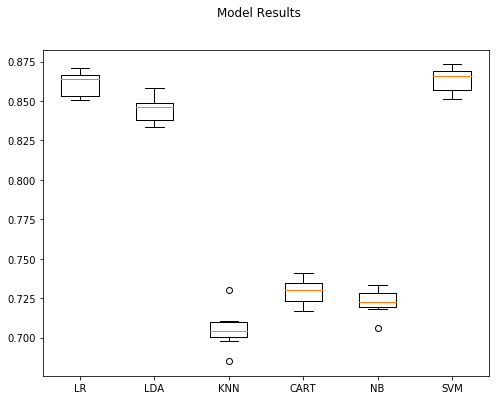

In [35]:
figure = plt.figure(figsize = (8,6))
figure.suptitle("Model Results")
axis = figure.add_subplot(111)
plt.boxplot(results.values())
axis.set_xticklabels(results.keys())
plt.show()

LR, LDA, and SVM were the clear winners here with SVM and LR kneck-in-kneck for top performance.  Both had high accuracy and lower standard deviations.

# Summary

In [31]:
%%html
<style>
table {float:left}
</style>

In this write-up we accomplished the following:

1. Created a set of word embeddings from the IMDb movie review text utilizing Word2vec
2. Clustered the embeddings utilizing a K-nearest neighbors algorithm into a set of centroids
3. Trained and evaluated the models from the last write-up against the centroid feature set

And finally, here is the baseline model's performance vs. the 'centroid' model we developed in this write-up:

|Model|Accuracy|Best Params                           |
|-------------------|--------|-----------------------------------|
|LR (baseline)      |86.35%  |{'LR__C': 0.1, 'LR__penalty': 'l1'}|
|Kaggle centroid    |84.68%  |Estimators = 100                   |
|SVM centroid       |86.36%  |Scikit-learn defaults              |

<div style="clear: both;"></div>

Similar to the last [last write-up](./Model-06.p2.ipynb) the work in this notebook was an interesting idea to explore, but ultimately didn't result in an overall performance increase versus the baseline model.  As such this line of exploration will be rejected in favor of keeping the current base line model and accuracy rating as benchmarks moving forward.